In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
path_prefix = './cs5228-2310-final-project/'
df_train = pd.read_csv(path_prefix + 'train.csv')
df_test = pd.read_csv(path_prefix + 'test.csv')

In [3]:
df_train.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


## Data Preprocessing

In [4]:
#data clean
df_train.isnull().sum()

rent_approval_date     0
town                   0
block                  0
street_name            0
flat_type              0
flat_model             0
floor_area_sqm         0
furnished              0
lease_commence_date    0
latitude               0
longitude              0
elevation              0
subzone                0
planning_area          0
region                 0
monthly_rent           0
dtype: int64

In [5]:
df_train.dtypes

rent_approval_date      object
town                    object
block                   object
street_name             object
flat_type               object
flat_model              object
floor_area_sqm         float64
furnished               object
lease_commence_date      int64
latitude               float64
longitude              float64
elevation              float64
subzone                 object
planning_area           object
region                  object
monthly_rent             int64
dtype: object

In [6]:
df_stock = pd.read_csv(path_prefix + 'auxiliary-data/auxiliary-data/sg-stock-prices.csv')
df_stock['date'] = pd.to_datetime(df_stock['date'])
df_stock['date'] = pd.to_datetime(df_stock['date'])
df_stock['date'] = df_stock['date'].dt.strftime('%Y-%m')
avg_adjusted_close = df_stock.groupby(['date'])['adjusted_close'].mean().reset_index()
df_train = pd.merge(df_train, avg_adjusted_close, left_on='rent_approval_date', right_on='date')
df_train.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent,date,adjusted_close
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600,2021-09,15.448564
1,2021-09,punggol,203a,punggol field,4 room,model a,85.0,yes,2004,1.398524,103.903863,0.0,matilda,punggol,north-east region,2400,2021-09,15.448564
2,2021-09,choa chu kang,458,choa chu kang avenue 4,executive,premium apartment,142.0,yes,2000,1.378101,103.736002,0.0,peng siang,choa chu kang,west region,1800,2021-09,15.448564
3,2021-09,sembawang,340a,sembawang close,5 room,premium apartment,110.0,yes,2001,1.447534,103.817892,0.0,sembawang central,sembawang,north region,2100,2021-09,15.448564
4,2021-09,bishan,117,bishan street 12,5 room,improved,121.0,yes,1987,1.347017,103.849987,0.0,bishan east,bishan,central region,2750,2021-09,15.448564


In [7]:
df_coe = pd.read_csv(path_prefix + 'auxiliary-data/auxiliary-data/sg-coe-prices.csv')
month_to_numeric = {
    'january': 1,
    'february': 2,
    'march': 3,
    'april': 4,
    'may': 5,
    'june': 6,
    'july': 7,
    'august': 8,
    'september': 9,
    'october': 10,
    'november': 11,
    'december': 12
}

df_coe['month'] = df_coe['month'].apply(lambda x: month_to_numeric[x.lower()])
df_coe['month'] = df_coe['month'].apply(lambda x: f'{x:02d}')

df_coe['date'] = df_coe['year'].astype(str) + '-' + df_coe['month']

df_coe['date_c'] = df_coe['date'].astype(str) + '-' + df_coe['category'].astype(str)

avg_price_bids_quota = df_coe.groupby('date_c').agg({
  'price': 'mean',
  'bids': 'mean',
  'quota': 'mean'
}).reset_index()



avg_price_bids_quota['date'] = avg_price_bids_quota['date_c'].str[:-2]  # Extract the date part
avg_price_bids_quota['category'] = avg_price_bids_quota['date_c'].str[-1]

avg_price_bids_quota['bids_quota_ratio'] = avg_price_bids_quota['bids'] / avg_price_bids_quota['quota']

avg_price_bids_quota.drop(columns=['date_c'], inplace=True)
print(avg_price_bids_quota)
for c in avg_price_bids_quota['category'].unique():
    filtered_data = avg_price_bids_quota[avg_price_bids_quota['category'] == c]
    original_column_names = filtered_data.columns.tolist()
    new_column_names = ['price'+c, 'bids'+c, 'quota'+c, 'date'+c, 'c'+c, 'bids_quota_ratio'+c]
    # print(new_column_names)
    rename_dict = {original_column_names[i]: new_column_names[i] for i in range(len(original_column_names))}
    filtered_data = filtered_data.rename(columns=rename_dict)
    print(filtered_data)
    filtered_data = filtered_data.reset_index()
    df_train = pd.merge(df_train, filtered_data[['c'+c, 'bids'+c, 'quota'+c, 'date'+c, 'price'+c, 'bids_quota_ratio'+c]], left_on='rent_approval_date', right_on='date'+c)
    
    
#df_train = pd.merge(df_train, avg_price_bids_quota[['date', 'price', 'category', 'bids_quota_ratio']], left_on='rent_approval_date', right_on='date')
df_train.head()

        price    bids   quota     date category  bids_quota_ratio
0     42055.0  1294.5   964.5  2021-01        a          1.342146
1     49550.5  1367.0  1020.5  2021-01        b          1.339539
2     38449.5   675.0   376.5  2021-01        c          1.792829
3     50694.5   731.5   466.5  2021-01        e          1.568060
4     41500.5  1162.0   894.0  2021-02        a          1.299776
..        ...     ...     ...      ...      ...               ...
119  121944.5   296.0   134.5  2023-06        e          2.200743
120   96101.0   742.0   584.5  2023-07        a          1.269461
121  118001.5   598.0   466.5  2023-07        b          1.281886
122   82112.0   140.0    73.0  2023-07        c          1.917808
123  121555.0   230.0   129.5  2023-07        e          1.776062

[124 rows x 6 columns]
       pricea   bidsa  quotaa    datea ca  bids_quota_ratioa
0     42055.0  1294.5   964.5  2021-01  a           1.342146
4     41500.5  1162.0   894.0  2021-02  a           1.299776
8

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,quotac,datec,pricec,bids_quota_ratioc,ce,bidse,quotae,datee,pricee,bids_quota_ratioe
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,...,121.0,2021-09,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703
1,2021-09,punggol,203a,punggol field,4 room,model a,85.0,yes,2004,1.398524,...,121.0,2021-09,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703
2,2021-09,choa chu kang,458,choa chu kang avenue 4,executive,premium apartment,142.0,yes,2000,1.378101,...,121.0,2021-09,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703
3,2021-09,sembawang,340a,sembawang close,5 room,premium apartment,110.0,yes,2001,1.447534,...,121.0,2021-09,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703
4,2021-09,bishan,117,bishan street 12,5 room,improved,121.0,yes,1987,1.347017,...,121.0,2021-09,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703


In [9]:
df_train.describe()
df_train['rent_approval_date'] = pd.to_datetime(df_train['rent_approval_date'])
df_train['rent_approval_year'] = df_train['rent_approval_date'].dt.year
df_train['rent_approval_month'] = df_train['rent_approval_date'].dt.month/12 + df_train['rent_approval_date'].dt.year

In [10]:
df_train

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,pricec,bids_quota_ratioc,ce,bidse,quotae,datee,pricee,bids_quota_ratioe,rent_approval_year,rent_approval_month
0,2021-09-01,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,...,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703,2021,2021.75
1,2021-09-01,punggol,203a,punggol field,4 room,model a,85.0,yes,2004,1.398524,...,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703,2021,2021.75
2,2021-09-01,choa chu kang,458,choa chu kang avenue 4,executive,premium apartment,142.0,yes,2000,1.378101,...,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703,2021,2021.75
3,2021-09-01,sembawang,340a,sembawang close,5 room,premium apartment,110.0,yes,2001,1.447534,...,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703,2021,2021.75
4,2021-09-01,bishan,117,bishan street 12,5 room,improved,121.0,yes,1987,1.347017,...,39500.5,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703,2021,2021.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2022-09-01,bukit panjang,623,Senja Road,5-room,improved,110.0,yes,2001,1.386256,...,65995.0,2.000000,e,278.5,170.5,2022-09,110250.0,1.633431,2022,2022.75
59996,2022-09-01,geylang,102,Aljunied Crescent,3-room,new generation,82.0,yes,1978,1.320481,...,65995.0,2.000000,e,278.5,170.5,2022-09,110250.0,1.633431,2022,2022.75
59997,2022-09-01,bishan,443,sin ming avenue,4-room,model a,105.0,yes,1990,1.358948,...,65995.0,2.000000,e,278.5,170.5,2022-09,110250.0,1.633431,2022,2022.75
59998,2022-09-01,jurong east,227,jurong east street 21,5-room,improved,120.0,yes,1984,1.341821,...,65995.0,2.000000,e,278.5,170.5,2022-09,110250.0,1.633431,2022,2022.75


In [11]:
#remove '-'
df_train['flat_type'] = df_train['flat_type'].str.replace('-', ' ')
df_train['flat_model'] = df_train['flat_model'].str.replace('-', ' ')

In [12]:
#map all categorical variables to the mean of monthly rent
def category_map_mean(df_origin):
    df = df_origin.copy()
    #map town decrease order
    grouby_town = df_train.groupby('town')['monthly_rent'].mean()
    town_map = grouby_town.index
    town_map_dict = {town_map[i]: grouby_town[town_map[i]] for i in range(len(town_map))}
    df['town'] = df['town'].apply(lambda x: town_map_dict[x] if x in town_map_dict else grouby_town.mean())

    #map block decrease order
    grouby_block = df_train.groupby('block')['monthly_rent'].mean()
    block_map = grouby_block.index
    block_map_dict = {block_map[i]: grouby_block[block_map[i]] for i in range(len(block_map))}
    df['block'] = df['block'].apply(lambda x: block_map_dict[x] if x in block_map_dict else grouby_block.mean())

    #map flat_type decrease order
    grouby_flat_type = df_train.groupby('flat_type')['monthly_rent'].mean()
    flat_type_map = grouby_flat_type.index
    flat_type_map_dict = {flat_type_map[i]: grouby_flat_type[flat_type_map[i]] for i in range(len(flat_type_map))}
    df['flat_type'] = df['flat_type'].apply(lambda x: flat_type_map_dict[x] if x in flat_type_map_dict else grouby_flat_type.mean())

    #map flat_model decrease order
    grouby_flat_model = df_train.groupby('flat_model')['monthly_rent'].mean()
    flat_model_map = grouby_flat_model.index
    flat_model_map_dict = {flat_model_map[i]: grouby_flat_model[flat_model_map[i]] for i in range(len(flat_model_map))}
    df['flat_model'] = df['flat_model'].apply(lambda x: flat_model_map_dict[x] if x in flat_model_map_dict else grouby_flat_model.mean())

    #map planning_area decrease order
    grouby_planning_area = df_train.groupby('planning_area')['monthly_rent'].mean()
    planning_area_map = grouby_planning_area.index
    planning_area_map_dict = {planning_area_map[i]: grouby_planning_area[planning_area_map[i]] for i in range(len(planning_area_map))}
    df['planning_area'] = df['planning_area'].apply(lambda x: planning_area_map_dict[x] if x in planning_area_map_dict else grouby_planning_area.mean())

    #map region decrease order
    grouby_region = df_train.groupby('region')['monthly_rent'].mean()
    region_map = grouby_region.index
    region_map_dict = {region_map[i]: grouby_region[region_map[i]] for i in range(len(region_map))}
    df['region'] = df['region'].apply(lambda x: region_map_dict[x] if x in region_map_dict else grouby_region.mean())

    #map street_name decrease order
    grouby_street_name = df_train.groupby('street_name')['monthly_rent'].mean()
    street_name_map = grouby_street_name.index
    street_name_map_dict = {street_name_map[i]: grouby_street_name[street_name_map[i]] for i in range(len(street_name_map))}
    df['street_name'] = df['street_name'].apply(lambda x: street_name_map_dict[x] if x in street_name_map_dict else grouby_street_name.mean())

    #map subzone decrease order
    grouby_subzone = df_train.groupby('subzone')['monthly_rent'].mean()
    subzone_map = grouby_subzone.index
    subzone_map_dict = {subzone_map[i]: grouby_subzone[subzone_map[i]] for i in range(len(subzone_map))}
    df['subzone'] = df['subzone'].apply(lambda x: subzone_map_dict[x] if x in subzone_map_dict else grouby_subzone.mean())

    #map rent_approval_date decrease order
    grouby_rent_approval_date = df_train.groupby('rent_approval_date')['monthly_rent'].mean()
    rent_approval_date_map = grouby_rent_approval_date.index
    rent_approval_date_map_dict = {rent_approval_date_map[i]: grouby_rent_approval_date[rent_approval_date_map[i]] for i in range(len(rent_approval_date_map))}
    df['rent_approval_date_mean'] = df['rent_approval_date'].apply(lambda x: rent_approval_date_map_dict[x] if x in rent_approval_date_map_dict else grouby_rent_approval_date.mean())

    
    

    return df

In [13]:
df_train_map_mean = category_map_mean(df_train)
df_train_map_mean.drop(['elevation'], axis=1, inplace=True)
df_train_map_mean.drop(['furnished'], axis=1, inplace=True)
df_train_map_mean.drop(['rent_approval_date'], axis=1, inplace=True)
#df_train_map_mean.drop(['latitude'], axis=1, inplace=True)
#df_train_map_mean.drop(['longitude'], axis=1, inplace=True)
df_train_map_mean

,town,block,street_name,flat_type,flat_model,floor_area_sqm,lease_commence_date,latitude,longitude,subzone,...,bids_quota_ratioc,ce,bidse,quotae,datee,pricee,bids_quota_ratioe,rent_approval_year,rent_approval_month,rent_approval_date_mean
0,2595.146199,2464.285714,2282.692308,2276.033233,2369.965462,67.0,1983,1.344518,103.738630,2542.158516,...,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703,2021,2021.75,2233.926780
1,2665.555556,2725.000000,2703.583618,2692.359176,2612.031305,85.0,2004,1.398524,103.903863,2695.619835,...,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703,2021,2021.75,2233.926780
2,2502.574398,2617.164179,2476.315789,2892.857143,2709.678998,142.0,2000,1.378101,103.736002,2509.045226,...,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703,2021,2021.75,2233.926780
3,2540.491010,2140.000000,2594.444444,2815.593875,2709.678998,110.0,2001,1.447534,103.817892,2592.332790,...,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703,2021,2021.75,2233.926780
4,2867.049408,2450.297619,2906.645570,2815.593875,2636.211052,121.0,1987,1.347017,103.849987,2892.229730,...,1.710744,e,359.5,202.0,2021-09,67351.0,1.779703,2021,2021.75,2233.926780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2493.746111,2396.296296,2501.327434,2815.593875,2636.211052,110.0,2001,1.386256,103.762201,2499.688474,...,2.000000,e,278.5,170.5,2022-09,110250.0,1.633431,2022,2022.75,2812.587413
59996,2484.265734,2485.000000,2443.636364,2276.033233,2369.965462,82.0,1978,1.320481,103.882473,2604.452055,...,2.000000,e,278.5,170.5,2022-09,110250.0,1.633431,2022,2022.75,2812.587413
59997,2867.049408,2364.102564,2703.061224,2692.359176,2612.031305,105.0,1990,1.358948,103.832788,2590.533333,...,2.000000,e,278.5,170.5,2022-09,110250.0,1.633431,2022,2022.75,2812.587413
59998,2595.146199,2466.091954,2728.925620,2815.593875,2636.211052,120.0,1984,1.341821,103.736088,2542.158516,...,2.000000,e,278.5,170.5,2022-09,110250.0,1.633431,2022,2022.75,2812.587413


## try with attributes > 0.3
* block
* street_name
* flat_type
* floor_area_sqm
* subzone
* rent_approval_date_mean
* price
## with method
* xgboost
* lgbm

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [69]:
def data_preprocess(df):
    df = df.copy()
    df_coe = pd.read_csv(path_prefix + 'auxiliary-data/auxiliary-data/sg-coe-prices.csv')
    month_to_numeric = {
        'january': 1,
        'february': 2,
        'march': 3,
        'april': 4,
        'may': 5,
        'june': 6,
        'july': 7,
        'august': 8,
        'september': 9,
        'october': 10,
        'november': 11,
        'december': 12
    }

    df_coe['month'] = df_coe['month'].apply(lambda x: month_to_numeric[x.lower()])
    df_coe['month'] = df_coe['month'].apply(lambda x: f'{x:02d}')

    df_coe['date'] = df_coe['year'].astype(str) + '-' + df_coe['month']
    df_coe = df_coe[['date', 'price']]
    avg_price_bids_quota = df_coe.groupby('date').mean().reset_index()

    df['price'] = df['rent_approval_date'].apply(lambda x: avg_price_bids_quota[avg_price_bids_quota['date'] == x]['price'].values[0])

    df['flat_type'] = df['flat_type'].str.replace('-', ' ')
    df = category_map_mean(df)
    df.drop(['elevation'], axis=1, inplace=True)
    df.drop(['furnished'], axis=1, inplace=True)
    df.drop(['latitude'], axis=1, inplace=True)
    df.drop(['longitude'], axis=1, inplace=True)
    df['rent_date'] = pd.to_datetime(df['rent_approval_date']).dt.year + pd.to_datetime(df['rent_approval_date']).dt.month/12
    df.drop(['rent_approval_date'], axis=1, inplace=True)
    
    df = df[['street_name', 'flat_type', 'town', 'floor_area_sqm', 'planning_area','subzone', 'rent_approval_date_mean', 'price','rent_date']]

    return df

In [16]:
df_train = pd.read_csv(path_prefix + 'train.csv')
df_test = pd.read_csv(path_prefix + 'test.csv')

In [17]:
df_train

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2021-09,ang mo kio,441,Ang Mo Kio Avenue 10,3 room,new generation,67.0,yes,1979,1.366050,103.854168,0.0,chong boon,ang mo kio,north-east region,2200
59996,2023-04,bukit merah,95a,henderson road,4-room,model a,83.0,yes,2019,1.286493,103.821434,0.0,henderson hill,bukit merah,central region,4100
59997,2022-06,tampines,862a,tampines street 83,5-room,improved,122.0,yes,1988,1.355064,103.936507,0.0,tampines west,tampines,east region,2250
59998,2023-01,bedok,67,Bedok Sth Avenue 3,5-room,standard,123.0,yes,1977,1.318974,103.944076,0.0,bedok south,bedok,east region,4700


In [70]:
df_train_X = data_preprocess(df_train)
#df_train_X = df_train_X.drop(['monthly_rent'], axis=1)
df_train_y = df_train['monthly_rent']
df_test_X = data_preprocess(df_test)
df_test_X

,street_name,flat_type,town,floor_area_sqm,planning_area,subzone,rent_approval_date_mean,price,rent_date
0,2375.000000,2400.673617,2503.252886,121.0,2503.252886,2427.604167,3069.581639,92845.000,2023.083333
1,2616.666667,2302.270969,2540.491010,100.0,2540.491010,2592.332790,2812.587413,92942.625,2022.750000
2,2567.261905,2302.270969,2646.808979,91.0,2646.808979,2395.588235,3262.248898,104442.375,2023.583333
3,2829.629630,1974.144364,2595.146199,74.0,2595.146199,2400.150150,2249.901768,51997.375,2021.666667
4,2280.416667,2400.673617,2595.146199,121.0,2595.146199,2400.150150,2449.322430,79016.000,2022.250000
...,...,...,...,...,...,...,...,...,...
29995,2568.143460,2302.270969,2665.555556,92.0,2665.555556,2654.294479,2755.309735,90883.875,2022.666667
29996,2388.732394,2302.270969,2540.491010,90.0,2540.491010,2473.678647,3103.949406,98624.125,2023.166667
29997,2264.655172,1974.144364,2416.700057,68.0,2416.700057,2378.606965,3189.212679,103440.750,2023.416667
29998,2526.829268,2892.857143,2466.298251,144.0,2466.298251,2497.040971,3103.949406,98624.125,2023.166667


In [19]:
df_train_X

,block,street_name,flat_type,town,floor_area_sqm,planning_area,subzone,rent_approval_date_mean,price,rent_date
0,2464.285714,2282.692308,1974.144364,2595.146199,67.0,2595.146199,2542.158516,2233.926780,54951.625,2021.750000
1,2357.720588,2384.124088,2302.270969,2438.227223,92.0,2438.227223,2360.371046,2517.128874,77035.625,2022.416667
2,2428.873239,2402.484472,1974.144364,2516.680515,67.0,2516.680515,2808.893871,2928.483245,89580.250,2022.833333
3,2375.714286,2691.237113,2892.857143,2686.857477,149.0,2686.857477,2610.338573,2249.901768,51997.375,2021.666667
4,2470.681818,2261.363636,1974.144364,2665.537634,68.0,2702.635659,2793.525180,2986.739659,99472.875,2022.916667
...,...,...,...,...,...,...,...,...,...,...
59995,2505.714286,2368.501529,1974.144364,2416.700057,67.0,2416.700057,2390.887097,2233.926780,54951.625,2021.750000
59996,3850.000000,3512.500000,2302.270969,2904.113924,83.0,2904.113924,2694.936709,3178.128128,104404.750,2023.333333
59997,2900.000000,2552.564103,2400.673617,2638.489123,122.0,2638.489123,2602.823315,2582.606383,83323.125,2022.500000
59998,2566.981132,2570.967742,2400.673617,2438.227223,123.0,2438.227223,2434.379786,3069.581639,92845.000,2023.083333


In [42]:
from scipy import stats

z_scores = stats.zscore(df_train_X)

threshold = 2

outlier_indices = np.where(np.abs(z_scores) > threshold)[0]
print(len(outlier_indices))

df_train_X = df_train_X.drop(outlier_indices)
df_train_y = df_train_y.drop(outlier_indices)

df_train_X.reset_index(drop=True, inplace=True)
df_train_y.reset_index(drop=True, inplace=True)

print(df_train_X)

22440
             block  street_name    flat_type         town  floor_area_sqm  \
0      2464.285714  2282.692308  1974.144364  2595.146199            67.0   
1      2357.720588  2384.124088  2302.270969  2438.227223            92.0   
2      2428.873239  2402.484472  1974.144364  2516.680515            67.0   
3      2470.681818  2261.363636  1974.144364  2665.537634            68.0   
4      2600.000000  2544.943820  2400.673617  2622.233325           110.0   
...            ...          ...          ...          ...             ...   
48494  2393.181818  2569.047619  1974.144364  2484.265734            68.0   
48495  2505.714286  2368.501529  1974.144364  2416.700057            67.0   
48496  2900.000000  2552.564103  2400.673617  2638.489123           122.0   
48497  2566.981132  2570.967742  2400.673617  2438.227223           123.0   
48498  2360.714286  2368.501529  1974.144364  2416.700057            67.0   

       planning_area      subzone  rent_approval_date_mean      price

In [21]:
import lightgbm as lgb
import xgboost as xgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [111]:
#cut 30% data as validation set
X_train, X_val, y_train, y_val = train_test_split(df_train_X, df_train_y, test_size=0.3, random_state=19260817)

In [104]:
#normalize y
y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean) / y_std
y_val = (y_val - y_mean) / y_std

MAE:  365.30248078070747
RMSE:  479.733506896472


<Axes: >

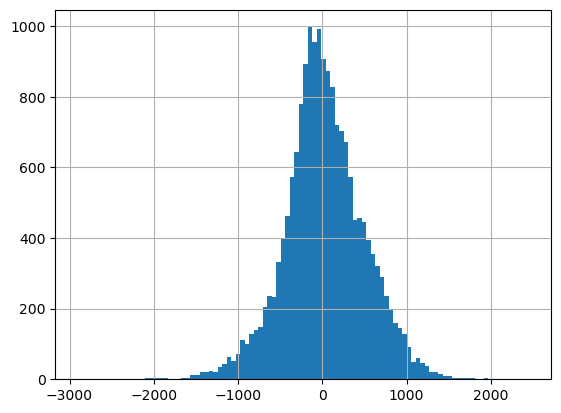

In [29]:
from xgboost import XGBRegressor
xgb_regressor = XGBRegressor(
    n_estimators=10000, 
    learning_rate=0.0005,
    )
xgb_regressor.fit(X_train, y_train)
y_pred = xgb_regressor.predict(X_val)
print('MAE: ', mean_absolute_error(y_val, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)

C:\Users\Concyclics\AppData\Local\Temp\ipykernel_21064\3547464200.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_val, hist=False, label='y_val')
C:\Users\Concyclics\AppData\Local\Temp\ipykernel_21064\3547464200.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, 

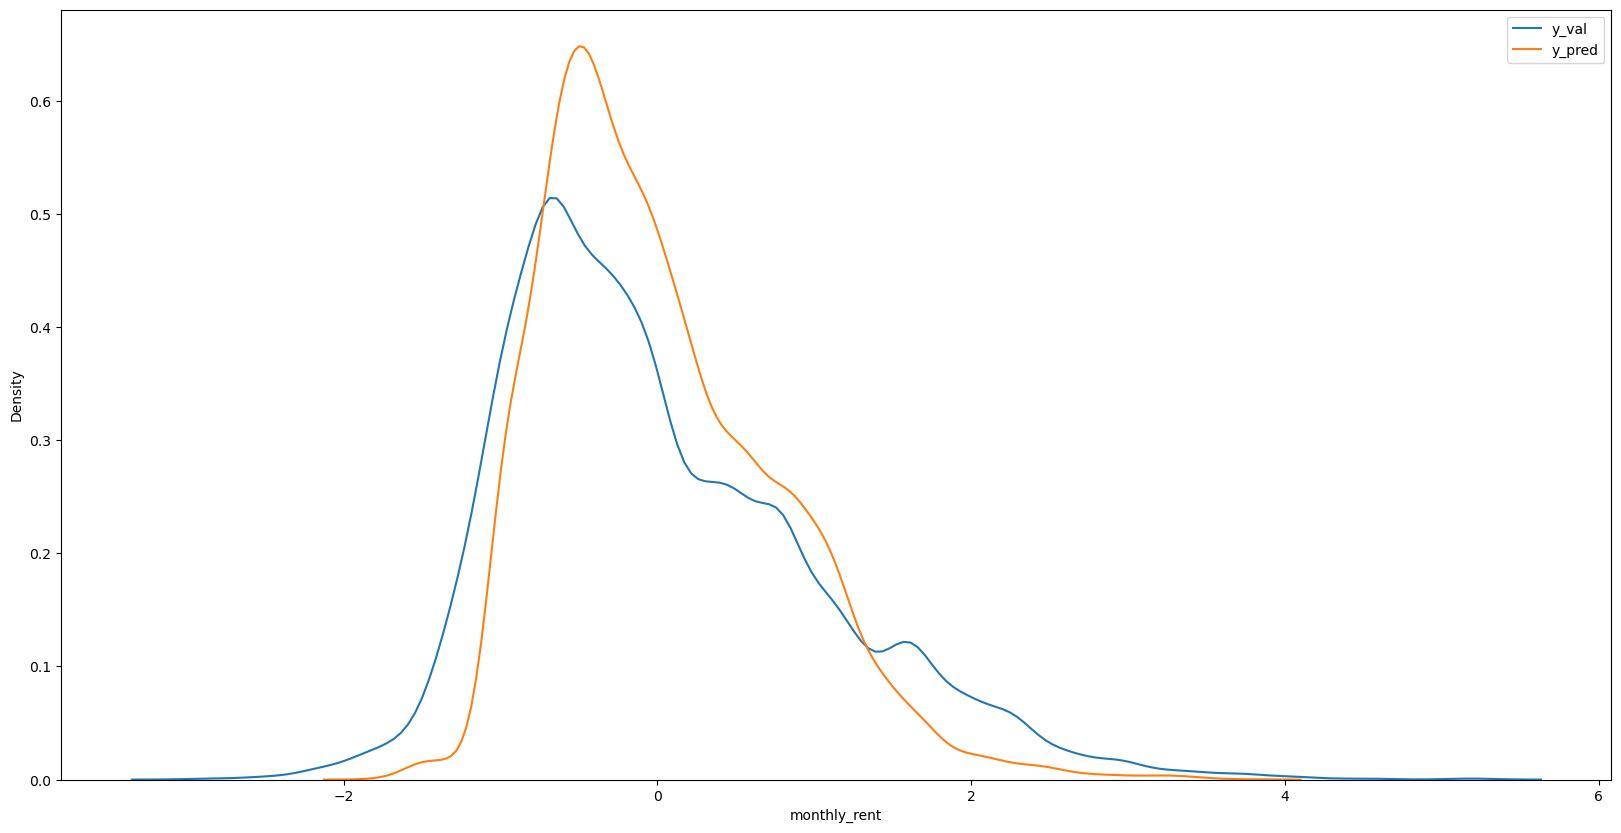

In [107]:
#plot distribution from predcit and real
plt.figure(figsize=(20, 10))
sns.distplot(y_val, hist=False, label='y_val')
sns.distplot(y_pred, hist=False, label='y_pred')
plt.legend()
plt.show()

In [27]:
#make submission
xgb_regressor = XGBRegressor(
    n_estimators=10000,
    learning_rate=0.001,
    )

xgb_regressor.fit(df_train_X, df_train_y)


submission = pd.read_csv(path_prefix + 'example-submission.csv')
submission['Predicted'] = xgb_regressor.predict(df_test_X)

submission.to_csv('submission.csv', index=False)

MAE:  266571.71107516164
RMSE:  349287.7256982124


<Axes: >

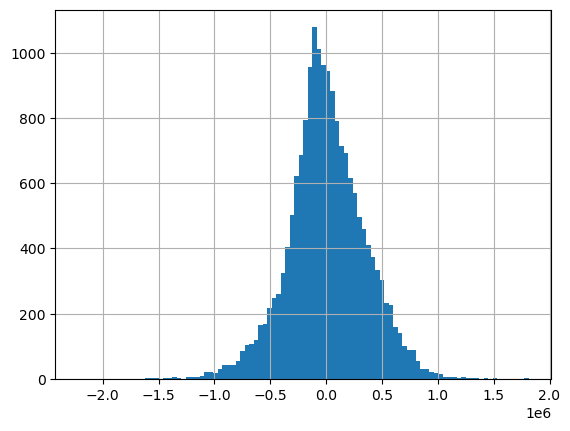

In [112]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

#model = DecisionTreeRegressor()
model = RandomForestRegressor(
    n_estimators=10000,
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=100,
    bootstrap=True,
    n_jobs=-1,
    random_state=19260817,)
#model = GradientBoostingRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
y_pred = y_pred * y_std + y_mean
y_val = y_val * y_std + y_mean
print('MAE: ', mean_absolute_error(y_val, y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 9
[LightGBM] [Info] Start training from score -0.000000
LGBM MAE:  368.078724037592
LGBM RMSE:  483.1416798672643


<Axes: >

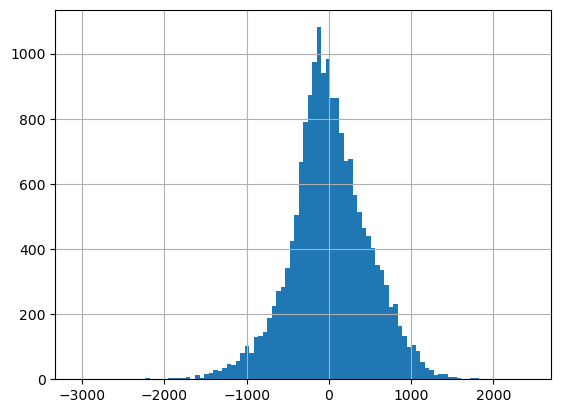

In [108]:
LGBM = LGBMRegressor(
    learning_rate=0.003,
    n_estimators=4000,
)

LGBM.fit(X_train, y_train)
y_pred = LGBM.predict(X_val)
y_pred = y_pred * y_std + y_mean
y_val = y_val * y_std + y_mean
print('LGBM MAE: ', mean_absolute_error(y_val, y_pred))
print('LGBM RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)



In [100]:
#submit with LGBM
LGBM = LGBMRegressor(
    learning_rate=0.003,
    n_estimators=4000,
)

LGBM.fit(df_train_X, df_train_y)

submission = pd.read_csv(path_prefix + 'example-submission.csv')
submission['Predicted'] = LGBM.predict(df_test_X)

submission.to_csv('submission.csv', index=False)



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 707
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 9
[LightGBM] [Info] Start training from score 2590.328333


In [96]:
#feature importance
lgb_model = LGBMRegressor()
features = X_train.columns
dict_feature_importance = {}

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_val)

original_rmse = mean_squared_error(y_val, y_pred, squared=False)

for feature in features:
    X_train_tmp = X_train.drop([feature], axis=1)
    X_val_tmp = X_val.drop([feature], axis=1)
    lgb_model.fit(X_train_tmp, y_train)
    y_pred = lgb_model.predict(X_val_tmp)
    dict_feature_importance[feature] = mean_squared_error(y_val, y_pred, squared=False) - original_rmse


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 9
[LightGBM] [Info] Start training from score 2586.378571
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 449
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 8
[LightGBM] [Info] Start training from score 2586.378571
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

In [97]:
for feature in features:
    print(feature, '\t\t', dict_feature_importance[feature])

street_name 		 4.734608592637073
flat_type 		 1.8292553994868967
town 		 -0.31630949404933517
floor_area_sqm 		 0.4579322704234414
planning_area 		 0.2500367516756796
subzone 		 1.2610174536113163
rent_approval_date_mean 		 0.2600907964165913
price 		 0.08182467317220699
rent_date 		 0.313917527634203


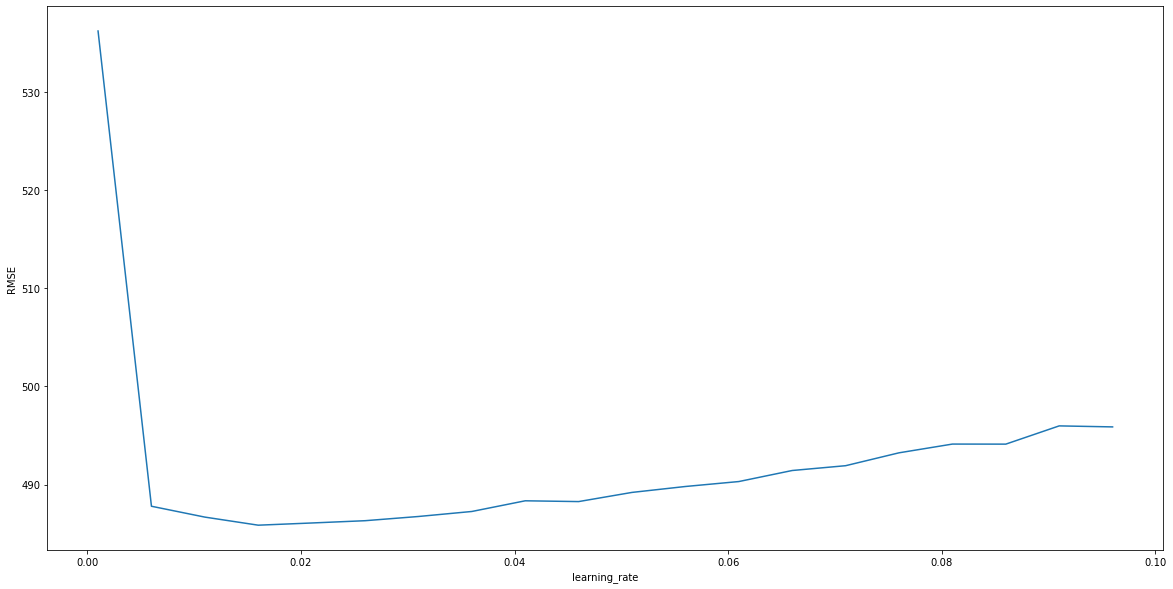

In [ ]:
#tuning with different learning rate
learning_rate_list = list(np.arange(0.001, 0.1, 0.005))
LGBM_RMSE_list = []
for learning_rate in learning_rate_list:
    LGBM = LGBMRegressor(
        learning_rate=learning_rate,
        n_estimators=1000,
    )

    LGBM.fit(X_train, y_train)
    y_pred = LGBM.predict(X_val)
    LGBM_RMSE_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))

plt.figure(figsize=(20, 10))
plt.plot(learning_rate_list, LGBM_RMSE_list)
plt.xlabel('learning_rate')
plt.ylabel('RMSE')
plt.show()

In [ ]:
print(learning_rate_list)
print(LGBM_RMSE_list)

[0.001, 0.006, 0.011, 0.016, 0.021, 0.026000000000000002, 0.031, 0.036000000000000004, 0.041, 0.046, 0.051000000000000004, 0.056, 0.061, 0.066, 0.07100000000000001, 0.076, 0.081, 0.08600000000000001, 0.091, 0.096]
[505.1465763362904, 492.54442895346574, 489.5115007436877, 488.12749381424715, 487.234967598313, 486.43030080137646, 486.5828965446134, 486.6669251273495, 486.63124548097124, 486.7582304233197, 486.6311661213862, 486.47709292086125, 486.510545132065, 486.4096140437656, 486.5259098679828, 486.6720949618832, 486.42651059255394, 486.4040339790541, 486.4040339790541]


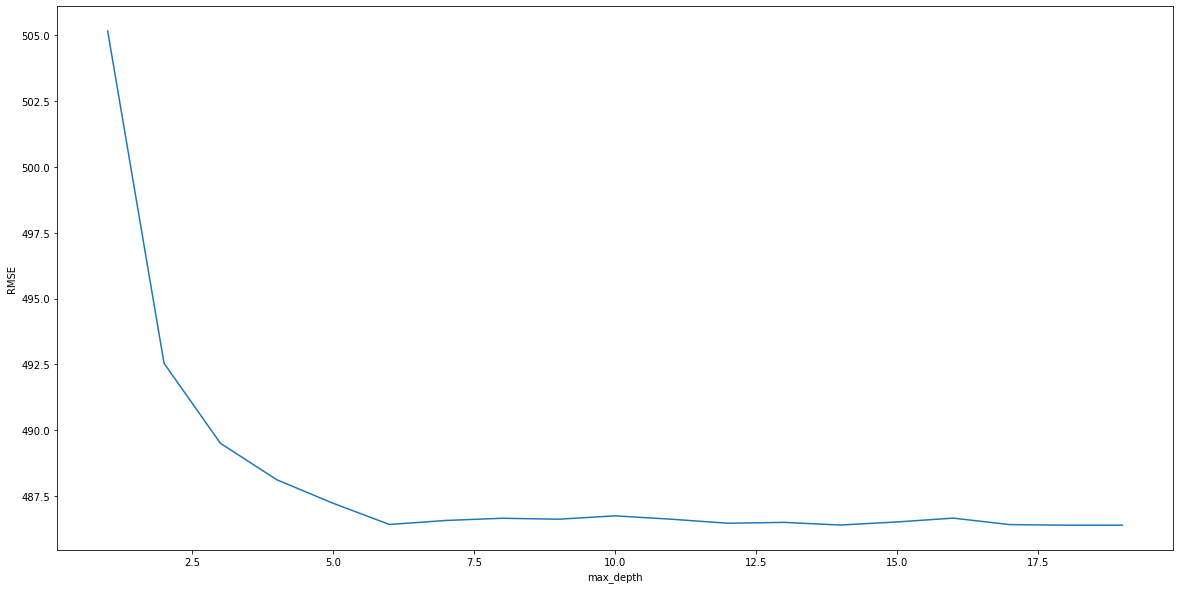

In [ ]:
#tuning with different depth
max_depth_list = list(np.arange(1, 20, 1))
LGBM_RMSE_list = []
for max_depth in max_depth_list:
    LGBM = LGBMRegressor(
        learning_rate=0.01,
        n_estimators=1000,
        max_depth=max_depth
    )

    LGBM.fit(X_train, y_train)
    y_pred = LGBM.predict(X_val)
    LGBM_RMSE_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))

plt.figure(figsize=(20, 10))
plt.plot(max_depth_list, LGBM_RMSE_list)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.show()

In [99]:
#tuning parameters with grid search
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': list(np.arange(1000, 11000, 1000)),
    'learning_rate': list(np.arange(0.001, 0.011, 0.001)),
}

LGBM = LGBMRegressor()

#RSME as the metric
grid_search = GridSearchCV(estimator=LGBM, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(grid_search.best_params_))
print('最佳模型得分:{0}'.format(grid_search.best_score_))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 42000, number of used features: 9
[LightGBM] [Info] Start training from score 2586.378571
参数的最佳取值:{'learning_rate': 0.003, 'n_estimators': 4000}
最佳模型得分:-489.8348251546615


In [ ]:
#tuning parameters with grid search
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': list(np.arange(1, 20, 1)),
    'num_leaves': list(np.arange(2, 100, 1)),
}

LGBM = LGBMRegressor(
    learning_rate=0.01,
)

#RSME as the metric
grid_search = GridSearchCV(estimator=LGBM, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(grid_search.best_params_))
print('最佳模型得分:{0}'.format(grid_search.best_score_))


Fitting 5 folds for each of 1862 candidates, totalling 9310 fits
参数的最佳取值:{'max_depth': 8, 'num_leaves': 99}
最佳模型得分:-525.6642401884303


In [ ]:
param_grid = {
    'min_child_samples': list(np.arange(1, 100, 1)),
    'min_child_weight': list(np.arange(0.001, 0.1, 0.001)),
}

LGBM = LGBMRegressor(
    learning_rate=0.01,
    max_depth=grid_search.best_params_['max_depth'],
    num_leaves=grid_search.best_params_['num_leaves'],
)

#RSME as the metric
grid_search = GridSearchCV(estimator=LGBM, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(grid_search.best_params_))
print('最佳模型得分:{0}'.format(grid_search.best_score_))

Fitting 5 folds for each of 9801 candidates, totalling 49005 fits


KeyboardInterrupt: 

In [ ]:
param_grid = {
    'bagging_fraction': list(np.arange(0.5, 1, 0.1)),
    'bagging_freq': list(np.arange(2, 10, 1)),
}

LGBM = LGBMRegressor(
    learning_rate=0.01,
    max_depth=9,
    num_leaves=99,
    min_child_samples=grid_search.best_params_['min_child_samples'],
    min_child_weight=grid_search.best_params_['min_child_weight'],
)

#RSME as the metric
grid_search = GridSearchCV(estimator=LGBM, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(grid_search.best_params_))
print('最佳模型得分:{0}'.format(grid_search.best_score_))

In [ ]:
param_grid = {
    'reg_alpha': list(np.arange(0, 1, 0.1)),
    'reg_lambda': list(np.arange(0, 1, 0.1)),
}

LGBM = LGBMRegressor(
    learning_rate=0.01,
    max_depth=9,
    num_leaves=99,
    min_child_samples=27,
    min_child_weight=0.001,
    bagging_fraction=grid_search.best_params_['bagging_fraction'],
    bagging_freq=grid_search.best_params_['bagging_freq'],
)

#RSME as the metric
grid_search = GridSearchCV(estimator=LGBM, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
print('参数的最佳取值:{0}'.format(grid_search.best_params_))
print('最佳模型得分:{0}'.format(grid_search.best_score_))

In [ ]:
LGBM = LGBMRegressor(
    learning_rate=0.01,
    n_estimators=50000,
    max_depth=9,
    num_leaves=99,
    min_child_samples=27,
    min_child_weight=0.001,
    bagging_fraction=0.5,
    bagging_freq=2,
    reg_alpha=grid_search.best_params_['reg_alpha'],
    reg_lambda=grid_search.best_params_['reg_lambda'],
)

LGBM.fit(X_train, y_train)
y_pred = LGBM.predict(X_val)
print('LGBM MAE: ', mean_absolute_error(y_val, y_pred))
print('LGBM RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)

In [ ]:
xgb = XGBRegressor(
    learning_rate=0.01,
    n_estimators=1000,
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
print('XGB MAE: ', mean_absolute_error(y_val, y_pred))
print('XGB RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
df_plot_diff = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})
df_plot_diff['diff'] = df_plot_diff['y_val'] - df_plot_diff['y_pred']
df_plot_diff['diff'].hist(bins=100)

In [ ]:
#tuning with different learning rate
learning_rate_list = list(np.arange(0.001, 0.02, 0.001))
XGB_RMSE_list = []
for learning_rate in learning_rate_list:
    xgb = XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=1000,
    )

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_val)
    XGB_RMSE_list.append(np.sqrt(mean_squared_error(y_val, y_pred)))

plt.plot(learning_rate_list, XGB_RMSE_list)
plt.xlabel('learning_rate')
plt.ylabel('RMSE')
plt.show()

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks


In [ ]:
def build_model(dim, activation='relu', optimizer='adam', loss='mse'):
    model = keras.Sequential([
        layers.Dense(dim, activation=activation, input_shape=[len(df_train_X.columns)]),
        layers.Dense(dim, activation=activation),
        layers.Dense(dim, activation=activation),
        layers.Dense(dim, activation=activation),
        layers.Dense(1, activation='linear')
    ])

    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    return model

In [ ]:
model = build_model(1024, activation='softplus', optimizer='adam', loss='mse')

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=10,
)

history = model.fit(
    df_train_X, df_train_y,
    validation_split=0.3,
    epochs=300,
    batch_size=4096,
    callbacks=[early_stopping]
)


Epoch 1/200
12/12 [==============================] - 0s 18ms/step - loss: 242681.7969 - mae: 377.2373 - val_loss: 234221.3594 - val_mae: 369.3957
Epoch 2/200
12/12 [==============================] - 0s 12ms/step - loss: 245132.5938 - mae: 379.5545 - val_loss: 239550.4062 - val_mae: 372.2088
Epoch 3/200
12/12 [==============================] - 0s 15ms/step - loss: 243425.9375 - mae: 377.8757 - val_loss: 241261.1875 - val_mae: 376.8472
Epoch 4/200
12/12 [==============================] - 0s 12ms/step - loss: 240905.5938 - mae: 376.2523 - val_loss: 237150.7656 - val_mae: 373.3318
Epoch 5/200
12/12 [==============================] - 0s 15ms/step - loss: 240885.3594 - mae: 376.0694 - val_loss: 238878.3438 - val_mae: 371.3596
Epoch 6/200
12/12 [==============================] - 0s 12ms/step - loss: 240137.7031 - mae: 375.0016 - val_loss: 236570.2031 - val_mae: 372.2632
Epoch 7/200
12/12 [==============================] - 0s 12ms/step - loss: 241053.8281 - mae: 376.1886 - val_loss: 234648.812